# Setup

## Load Modules

In [1]:
%matplotlib notebook

# Standard library
import os.path, logging

# External modules
from neuron import h
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bluepyopt.ephys as ephys

# Our modules
from bgcellmodels.common import electrotonic, treeutils
from bgcellmodels.common import logutils
from bgcellmodels.morphology import morph_ni, morph_gui

from bgcellmodels.models.STN.GilliesWillshaw import mechanisms
from bgcellmodels.models.STN import Miocinovic2006 as miocinovic
from bgcellmodels.models.axon.mcintyre2002 import AxonMcintyre2002

## Settings

In [2]:
default_template = 'STN_morph_arcdist'

class CellModel(object):
    """ Wrapper class to store NEURON cell data. """
    pass

# Global variables
nrnsim = ephys.simulators.NrnSimulator(dt=0.025, cvode_active=False)
logger = logging.getLogger('STN_MORPH')
logger.setLevel(logging.DEBUG)
logging.basicConfig(format=logutils.DEFAULT_FORMAT)

## Functions

In [3]:
def template_with_morphology(
        template_name, morphology_path,
        streamlines_path, streamline_index=0):
    """
    Instantiate template with given morphology and axon
    """
    miocinovic.load_template(template_name) # xopen -> loads once
    template_constructor = getattr(h, template_name)
    
    # Instantiate template
    icell = template_constructor()
    icell.with_extracellular = 0

    # Load morphology into template
    
    morphology = ephys.morphologies.NrnFileMorphology(morphology_path, do_replace_axon=False)
    morphology.instantiate(sim=nrnsim, icell=icell)

    # Setup biophysical properties
    icell.del_unused_sections()
    icell.insert_biophys()
    nseg_extra = electrotonic.set_min_nseg_hines(icell.all, f_lambda=100.0)
    print("Created {} extra segments to satisfy Hines' rule".format(nseg_extra))
    icell.set_biophys_spatial()

    # Load axon coordinates
    axon_builder = AxonMcintyre2002(logger=logger)
    tracks_coords = morph_ni.load_streamlines(streamlines_path, max_num=1, min_length=2.0)
    axon_coords = tracks_coords[0]

    # Build axon
    axon_initial_secs = list(icell.axonal)
    axon_terminal_secs = treeutils.leaf_sections(axon_initial_secs[0], subtree=True)
    assert len(axon_terminal_secs) == 1
    axon_end_sec = axon_terminal_secs[0]

    axon = axon_builder.build_along_streamline(axon_coords,
                terminate='nodal_cutoff', interp_method='cartesian',
                parent_cell=icell, parent_sec=axon_end_sec,
                connection_method='translate_axon_start')
    
    wrapper = CellModel()
    wrapper.icell = icell
    wrapper.axon = axon

    return wrapper

# Miocinovic (2006)

## Make Cell

In [4]:
morphology_path = os.path.join(miocinovic.pkg_dir, 'morphologies/type1RD_axonless-with-AIS.swc')
streamlines_path = '/home/luye/Documents/mri_data/Waxholm_rat_brain_atlas/WHS_DTI_v1_ALS/S56280_track_filter-ROI-STN.tck'

model = template_with_morphology(
                default_template, morphology_path,
                streamlines_path, streamline_index=0)

icell = model.icell

# Verify axon creation:
# print(list(icell.axonal))
# h.topology()

DEBUG:STN_MORPH@axon_base.py:536: Created 113 axonal compartments
DEBUG:STN_MORPH@axon_base.py:536: Updated SectionList 'all' of STN_morph_arcdist[0]
DEBUG:STN_MORPH@axon_base.py:536: Updated SectionList 'axonal' of STN_morph_arcdist[0]


One point section Import3d_Section[1] ending at line 2 has been removed
	and child Import3d_Section[24] reattached
Created 21 extra segments to satisfy Hines' rule
maximum dendrite length in STN_morph_arcdist[0]  is 857.16795 


In [9]:
axon_leaf_secs = treeutils.leaf_sections(list(icell.axonal)[0], subtree=True)
dend_leaf_secs = treeutils.leaf_sections(list(icell.basal)[0], subtree=True)

leaves = dend_leaf_secs
root = icell.soma[0]

## Electrotonic Properties

In [6]:
# # First draw skeleton to get an idea
# plt.figure()
# ax = plt.subplot(111, projection='3d')
# ax.view_init(90,90) # set azimut and elevation
# ax.set_zlim((-1,1)) # prevent rounding errors
# ax.set_axis_off() # hide x,y,z axes and grid

# # Plot shape of our cell
# morph_gui.shapeplot(h, ax)

# # Mark location of leaf section to refer to plots
# marker_colors = 'rgby'
# for i, leaf_sec in enumerate(leaves[:2]):
#     morph_gui.mark_locations(h, leaf_sec, 1.0, 
#                              label=leaf_sec.name(),
#                              markspec='o'+marker_colors[i])

# plt.legend()
# plt.show()

In [11]:
measure_funcs = {
    'Ztransfer': electrotonic.measure_transfer_impedance,
    'Ai': electrotonic.measure_current_transfer,
    'Av': electrotonic.measure_voltage_transfer,
    'Zin': electrotonic.measure_input_impedance,
}

leaf_path_measurements = electrotonic.measure_along_paths(root, leaves, measure_funcs)

<IPython.core.display.Javascript object>


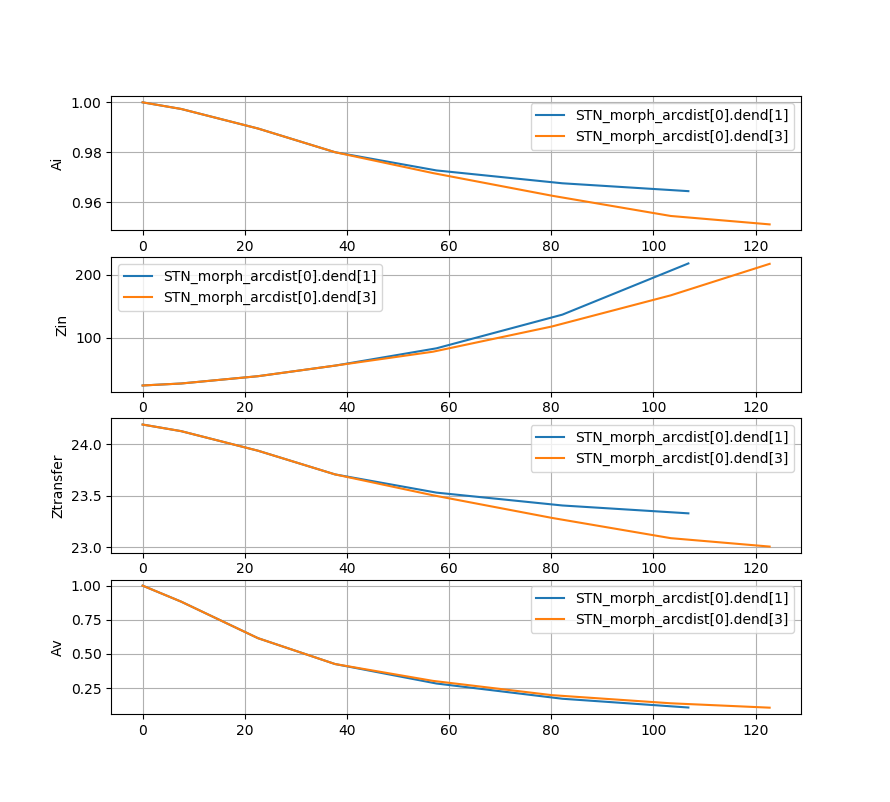

In [14]:
plotted_measures = measure_funcs.keys()
fig, axes = plt.subplots(len(plotted_measures))

measures_ylims = {
    'Ztransfer': (0, 50),
    'Ai': (0.5, 1.05),
    'Av': (0, 1.1),
    'Zin': (0, 1000.0),
}

for i, measure in enumerate(plotted_measures):
    ax = axes[i]
    
    # Plot the same measure for each leaf in the same axis
    for j, leaf in enumerate(leaves[:2]):
        ax.plot(leaf_path_measurements[j]['pathlen_micron'],
                leaf_path_measurements[j][measure],
                label=leaf.name())
        
        # ax.set_ylim(measures_ylims[measure])
        ax.legend() # show line labels
        ax.grid(True)
        ax.set_ylabel(measure)

## Stimulation Protocols

In [ ]:
# TODO: see evalmodel/stn_model_evaluation or use BluePyOpt wrapper classes for more general approach

# Bevan, Chu (2016)

Can be found on neuromorpho.org using following searches
- [keyword 'subthalamic', sorty by archive](http://neuromorpho.org/KeywordBrowseView.jsp?count=52&keywords=%22subthalamic%22&browseBy=archive)
- [search by brain region 'basal ganglia'](http://neuromorpho.org/byregion.jsp#top)